In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from memory import Memory
from config import Config
from process import play, optimize, evaluate
from deepfour import DeepFour
from simulation.mcts import dirichlet_noise, mcts
from simulation.game import Game
from simulation.nodes import StateNode

import numpy as np

In [20]:
policy_estimate, value_estimate = np.array([0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857, 0.142857]), np.random.normal(0.0, 0.05)

In [39]:
dirichlet_noise(policy_estimate, 0.1, 0.2)

array([0.13, 0.13, 0.22, 0.13, 0.13, 0.13, 0.13])

In [90]:
config = Config()
memory = Memory(config)

In [82]:
n=42
1.18-(9*n/350)

0.09999999999999987

In [91]:
net = DeepFour(config)
# net.save('best')
# net.save('0')
# net.save('checkpoint')

In [53]:
result.child_number_visits

array([28., 29., 41., 72., 28., 30., 27.], dtype=float32)

In [84]:
game = Game()
game.play(3)
game.play(0)
game.play(4)
game.play(0)
game.play(4)
game.presentation()
enc = game.encoded()
enc

[[' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['X' ' ' ' ' ' ' 'O' ' ' ' ']
 ['X' ' ' ' ' 'O' 'O' ' ' ' ']]


array([[[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 1, 0, 0]]])

In [89]:
from copy import deepcopy

game = Game()
game.play(0)
game.play(6)
game.play(2)
game.play(4)
game.play(3)
game.play(4)
game.play(5)
game.play(4)
game.play(5)
game.play(2)
# game.play(x)
# game.play(x)
# game.presentation()
root = StateNode(game=game, c_puct=2, depth=1)

# Run UCT search
result = mcts(deepcopy(root),
    search_depth=512,
    net=net,
    add_noise=True,
    noise_eps=config.noise_eps,
    dirichlet_alpha=config.dirichlet_alpha)

1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
3
3
2
2
2
2
2
2
2
2
2
2
2
2
3
2
3
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
3
3
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2


In [ ]:
net = DeepFour(config)
# net.save('best')
# net.save('0')
# net.save('checkpoint')

In [13]:
json.loads(loaded_model_json)

{'name': 'connect4_model',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': [None, 2, 6, 7],
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'conv2d_1',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d_1',
    'trainable': True,
    'filters': 128,
    'kernel_size': [3, 3],
    'strides': [1, 1],
    'padding': 'same',
    'data_format': 'channels_first',
    'dilation_rate': [1, 1],
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': {'class_name': 'L1L2',
     'config': {'l1': 0.0, 'l2': 9.999999747378752e-05}},
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_con

In [14]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = Model.from_config(json.loads(loaded_model_json))

In [5]:
net.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 6, 7, 3)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 7, 128)    3584        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 6, 7, 128)    512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 6, 7, 128)    0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [15]:
loaded_model.summary()

Model: "connect4_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2, 6, 7)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 6, 7)    2432        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 6, 7)    512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 6, 7)    0           batch_normalization_1[0][0]      
_____________________________________________________________________________________

In [8]:
import os

games = []

memory.load_memories()

for filename in memory.sorted_games:
    if filename.endswith('.npy'):
        game = np.load(os.path.join(memory.folder, filename), allow_pickle=True)
        games.append(game)
            
games = np.array(games)

In [99]:
starters = []
winners = []

for game_nr in range(len(games)):
    start_player = games[game_nr][0][0][0][0][2]
    winner = games[game_nr][-1][0][0][0][2]
    starters.append(start_player)
    winners.append(winner)

In [100]:
starters[-1], winners[-1]

(1, 0)

In [101]:
np.mean(starters)

0.49232100367726583

In [102]:
np.mean(winners)

0.500324464633355

In [103]:
comb = np.column_stack([starters, winners])
comb

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [0, 0],
       [1, 0]])

In [104]:
comb[-1]

array([1, 0])

In [105]:
np.mean(comb[:,0] == comb[:,1])

0.5507246376811594

In [4]:
net = DeepFour(config)
net.load('best')

Using TensorFlow backend.
/home/jules/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


Loaded network: DeepFour-V3.best


In [5]:
game = Game()

In [6]:
boards = np.array([game.encoded()])
policies = np.array([np.array([0, 0, 0, 0, 0, 0, 0])])
values = np.array([1])

In [7]:
history = net.model.fit(boards, [policies, values], batch_size=1, shuffle=False, epochs=1)

/home/jules/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(values, collections.Sequence):



Epoch 1/1
1/1 [==============================] - 0s 471ms/step - loss: 2.9280 - policy_loss: 0.0000e+00 - value_loss: 2.8831 - value_mean: -0.6980


In [9]:
0.55*40

22.0

In [10]:
0.45*40

18.0

In [8]:
history.history

{'loss': [2.927992105484009],
 'policy_loss': [0.0],
 'value_loss': [2.883083],
 'value_mean': [-0.6979644]}

In [12]:
np.mean(history.history['loss'])

0.9326997995376587

In [4]:
import keras.backend as K

In [6]:
net.update_lr(3000)

In [6]:
memory.load_memories()
a, _, _ = memory.all_moves()

In [7]:
a.shape

(60000, 6, 7, 3)

In [4]:
opt = optimize.OptimizeProcess(config, memory)

Using TensorFlow backend.


Loaded network: DeepFour-V2.checkpoint


In [6]:
opt.last_version()

10

In [3]:
memory.load_memories()
memory.memory

deque([array([array([[[0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0]],
       
              [[0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0]],
       
              [[0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0]],
       
              [[0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0]],
       
              [[0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0],
               [0, 0, 0]],
       
              [[0, 0, 0],
            

In [21]:
_, _, values = memory.get_minibatch()

In [22]:
np.mean(values)

-0.0009765625

In [5]:
import mlflow
from process import play

mlflow.set_experiment('test')

with mlflow.start_run(run_name=f'{config.model}-self'):
    play = play.SelfPlayProcess(config, memory)
    play.play(True)

/home/jules/anaconda3/lib/python3.7/site-packages/py4j/java_collections.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import (
/home/jules/anaconda3/lib/python3.7/site-packages/pyspark/resultiterable.py:23: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class ResultIterable(collections.Iterable):
Using TensorFlow backend.


Loaded network: DeepFour-V3.best
Move: X 


Q value:     -0.0
Value pred:  0.0 

Policy pred: | 0.14 | 0.14 | 0.14 | 0.14 | 0.14 | 0.14 | 0.14 |
Policy:      | 0.13 | 0.13 | 0.23 | 0.13 | 0.13 | 0.13 | 0.13 |



/home/jules/anaconda3/lib/python3.7/site-packages/tensorflow_core/contrib/learn/python/learn/learn_io/generator_io.py:26: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Container


TypeError: sequence item 0: expected str instance, numpy.float32 found

In [4]:
net.save('0')
net.save('best')
net.save('checkpoint')

# Viz

Loaded network: DeepFour-V2.checkpoint


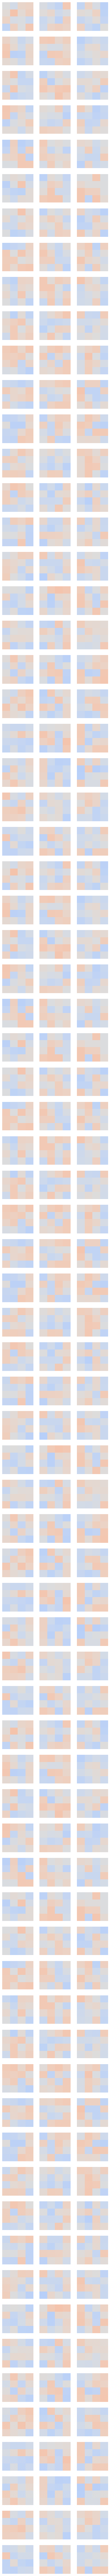

In [10]:
import matplotlib.pyplot as plt

net = DeepFour(Config())
net.load('checkpoint')

layer  = net.model.layers[1]

x = layer.get_weights()

weights = x[0]
s = weights.shape

fig = plt.figure(figsize=(s[2]*2, s[3]*2))  # width, height in inches
channel = 0
filter = 0
for i in range(s[2] * s[3]):
    sub = fig.add_subplot(s[3], s[2], i + 1)
    sub.imshow(weights[:, :, channel, filter], cmap='coolwarm', clim=(-.3, .3), aspect="auto")
    plt.axis('off')
    channel = (channel + 1) % s[2]
    filter = (filter + 1) % s[3]